In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [21]:
df = pd.read_csv(r"C:\Users\julie\OneDrive\Skrivebord\Computational Data Analysis, 02582\Assignment 2\data\HR_data.csv", index_col=0)

# df.columns
# df["Cohort"]

In [80]:
df = df.dropna(axis=1, how="any") # Drop columns with any NaN values
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Random shuffle of rows

target_cols = ["Cohort", "Phase", "Round"] # Target columns to predict
X_cols = list(set(df.columns) - set(target_cols))

X = df[X_cols]
y = df[target_cols]

[N, p] = X.shape
minX = list(np.min(X, axis=0)) # data range min
maxX = list(np.max(X, axis=0)) # data range max


test_size = 0.2
test_split = len(X) - int(len(X) * test_size)

X_train, y_train = np.array(X[:test_split]), np.array(y[:test_split])
X_test, y_test = np.array(X[test_split:]), np.array(y[test_split:])


## Basic K-means clustering

In [ ]:
## K-means clustering

clusters = 10 # Number of clusters

kmeans = KMeans(n_clusters = clusters, n_init = 1, random_state = 1, max_iter = 1)
kmeans.fit(X_train)

# Test the clustering
y_pred = kmeans.predict(X_test)
y_pred_train = kmeans.predict(X_train)

# NOTE Find a way to evaluate the clustering, since y are string values

## Investigate the clustering results
cluster = 5 # Cluster to investigate

# Find the index of the cluster in y_test
cluster_index = np.where(y_pred == cluster)[0]
cluster_y = y_test[cluster_index] 
print(cluster_y)

[['D1_4' 'phase1' 'round_3']
 ['D1_1' 'phase1' 'round_2']]


## Gap-statistic to select K for K-means clustering, week 9 ex3

In [96]:
clustersNr = 50
list_of_clusters = range(1,clustersNr+1)
Nsim = 50
W = np.zeros(clustersNr) # For actual data
Wu = np.zeros((clustersNr, Nsim)) # For simulated data
for nrClusters in list_of_clusters: # Want actual number included
    # kmeans first
    kmeans = KMeans(n_clusters=nrClusters, random_state=0).fit(X)
    
    # Then Compute within-class dissimilarity W given X (the data), C (the cluster centers)
    # and labelCluster (the predicted cluster numbers)
    labelCluster = kmeans.labels_ # predicted cluster numbers
    C = kmeans.cluster_centers_ # cluster centers
    
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((X.iloc[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        
        # perform K-means on the simulated data
        kmeans = KMeans(n_clusters=nrClusters, random_state=0).fit(Xu)
                
        # Compute within-class dissmiliarity for the simulated data Wu given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and labelClusterU (the predicted cluster numbers)
        # for the simulated data).
        labelClusterU = kmeans.labels_
        Cu = kmeans.cluster_centers_

        for cluster in range(1, nrClusters + 1):
            Ik = np.where(labelClusterU == cluster - 1)[0]
            dk = np.sum((Xu[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dk = np.sum(dk)
            Wu[nrClusters-1,j] += Dk

        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

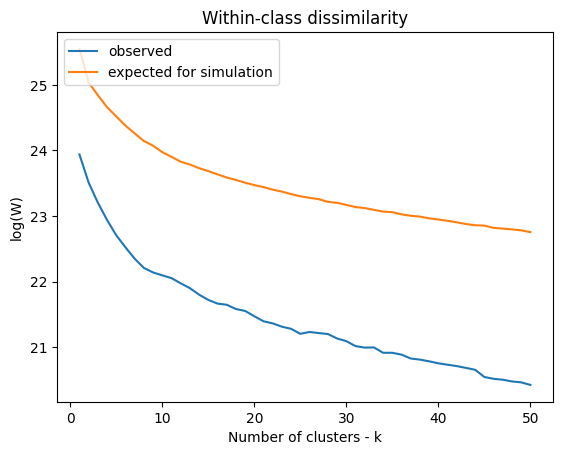

In [97]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

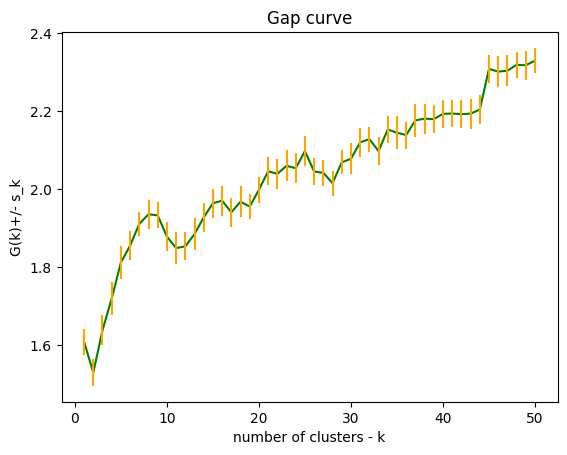

Gap-statistic, optimal K = 1


In [98]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()


# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = clustersNr
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_of_clusters[K_opt[0]])